# Multi-Head Attention from Scratch Using CuPy

In this notebook, we will implement the **Multi-Head Attention** mechanism from scratch using **CuPy**, a GPU-accelerated library similar to NumPy. The multi-head attention mechanism is a key component of the Transformer model, enabling it to attend to different parts of the input simultaneously.

---

## 1. Overview of Multi-Head Attention

Multi-head attention allows the model to have multiple attention "heads," each of which focuses on different parts of the input sequence. Each head computes its own attention values, and the results are concatenated and transformed into the final output.

The steps involved in multi-head attention:
- **Linear transformations**: Apply learned weight matrices to the queries (Q), keys (K), and values (V).
- **Scaled Dot-Product Attention**: For each head, compute the attention scores and apply them to the values.
- **Concatenation**: Concatenate the outputs from all heads.
- **Final Linear Transformation**: Apply a final linear transformation to the concatenated output.

Mathematically, the output of the multi-head attention mechanism can be written as:

$$
\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, \dots, \text{head}_h)W^O
$$
where each attention head is computed as:

$$
\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V)
$$
---

## 2. CuPy Setup

Before we begin, make sure you have **CuPy** installed. You can install it via:

```bash
!pip install cupy


In [1]:
import sys 
import numpy as np
import re
import cupy as cp
import pickle
import time
import numpy as np 
import jax.numpy as jnp
import pandas as pd
import numpy as np
import jax
from tqdm import tqdm
from pathlib import Path
np.set_printoptions(edgeitems=30, linewidth=100000, formatter=dict(float=lambda x: "%.3g" % x)) 
def softmax(x, axis=-1):
    # Subtract the max value for numerical stability
    e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
    return e_x / np.sum(e_x, axis=axis, keepdims=True)

num_classes=2
word2vec_len = 10
num_phrases = 3
words_per_phrase = 7 
dk = dv = 8
 
num_heads=4
 
 
inputs = np.random.rand(num_phrases,words_per_phrase, word2vec_len)
target = softmax(np.random.rand(num_phrases,num_classes))

Q = np.random.rand(word2vec_len, dk) / jnp.sqrt(word2vec_len)
K = np.random.rand(word2vec_len, dk) / jnp.sqrt(word2vec_len)
V = np.random.rand(word2vec_len, dv) / jnp.sqrt(word2vec_len)
inputs.shape,Q.shape,K.shape,V.shape

((3, 7, 10), (10, 8), (10, 8), (10, 8))

### Consideriamo input formato da 3 frasi composte da 7 parole ciasuna ed ogni parola avente rappresentazione vettoriale di dimensione 10. Mentre vogliamo dopo l'attentione che ogni parola abbia rappresentazione vettoriale di 8 

In [2]:
inputs# each input phrase is made by 13 words having lenght 15

array([[[0.242, 0.61, 0.0936, 0.483, 0.58, 0.00754, 0.831, 0.137, 0.233, 0.108],
        [0.513, 0.817, 0.873, 0.995, 0.745, 0.264, 0.188, 0.815, 0.471, 0.299],
        [0.86, 0.0837, 0.148, 0.718, 0.237, 0.302, 0.0181, 0.676, 0.218, 0.335],
        [0.459, 0.45, 0.872, 0.321, 0.0168, 0.722, 0.212, 0.253, 0.361, 0.975],
        [0.794, 0.717, 0.111, 0.188, 0.639, 0.325, 0.614, 0.125, 0.604, 0.279],
        [0.308, 0.828, 0.988, 0.188, 0.773, 0.489, 0.11, 0.477, 0.142, 0.534],
        [0.357, 0.0608, 0.438, 0.429, 0.543, 0.907, 0.356, 0.313, 0.3, 0.193]],

       [[0.468, 0.332, 0.491, 0.848, 0.0648, 0.44, 0.86, 0.551, 0.621, 0.751],
        [0.711, 0.899, 0.689, 0.779, 0.106, 0.275, 0.0318, 0.161, 0.0841, 0.708],
        [0.86, 0.581, 0.934, 0.558, 0.138, 0.312, 0.54, 0.751, 0.0094, 0.316],
        [0.359, 0.0142, 0.826, 0.763, 0.45, 0.452, 0.509, 0.864, 0.974, 0.738],
        [0.192, 0.369, 0.948, 0.0747, 0.749, 0.342, 0.826, 0.925, 0.216, 0.693],
        [0.196, 0.668, 0.241, 0.492, 

In [3]:
inputs.shape,Q.shape

((3, 7, 10), (10, 8))

In [4]:
jnp.matmul(inputs, Q) 

Array([[[0.387, 0.723, 0.607, 0.492, 0.419, 0.662, 0.492, 0.675],
        [0.797, 1.46, 1.05, 0.935, 0.61, 1.01, 0.928, 1.15],
        [0.619, 0.877, 0.587, 0.517, 0.513, 0.61, 0.471, 0.626],
        [0.591, 0.983, 0.844, 0.96, 0.566, 0.508, 0.675, 0.806],
        [0.569, 0.97, 0.749, 0.693, 0.678, 0.715, 0.607, 0.812],
        [0.53, 1.11, 0.899, 0.891, 0.411, 0.678, 0.64, 0.914],
        [0.422, 0.727, 0.613, 0.641, 0.523, 0.512, 0.59, 0.71]],

       [[0.697, 1.15, 0.97, 0.961, 0.749, 0.852, 0.828, 1.01],
        [0.731, 1.09, 0.815, 0.806, 0.493, 0.621, 0.704, 0.764],
        [0.671, 1.13, 0.907, 0.9, 0.52, 0.777, 0.664, 0.812],
        [0.723, 1.33, 1, 1.03, 0.782, 0.899, 0.855, 1.16],
        [0.481, 1.14, 1.02, 1.01, 0.496, 0.859, 0.56, 1.04],
        [0.444, 0.862, 0.674, 0.597, 0.466, 0.595, 0.693, 0.773],
        [0.517, 1.06, 0.943, 0.919, 0.485, 0.816, 0.576, 0.89]],

       [[0.546, 0.939, 0.605, 0.666, 0.617, 0.542, 0.548, 0.694],
        [0.723, 1.37, 1.06, 1.01, 0.604, 

### Avendo fissato il numero di teste per il attezione ogni matrice Qval, Kval, Vval viene suddivisa in 4 parti uguali di 2 colonne. Otteniamo un array di 4 elementi che per ogni frase riportano le prime due colonne come di seguito.

In [5]:
len(jnp.array_split(jnp.matmul(inputs, Q),num_heads,axis=2))

4

In [6]:
jnp.array_split(jnp.matmul(inputs, Q),num_heads,axis=2)[0]# so i have basically num_heads chuncks of the Qval this is a list not array structure

Array([[[0.387, 0.723],
        [0.797, 1.46],
        [0.619, 0.877],
        [0.591, 0.983],
        [0.569, 0.97],
        [0.53, 1.11],
        [0.422, 0.727]],

       [[0.697, 1.15],
        [0.731, 1.09],
        [0.671, 1.13],
        [0.723, 1.33],
        [0.481, 1.14],
        [0.444, 0.862],
        [0.517, 1.06]],

       [[0.546, 0.939],
        [0.723, 1.37],
        [0.75, 1.27],
        [0.58, 1.33],
        [0.639, 1.22],
        [0.539, 1.13],
        [0.47, 1.04]]], dtype=float32)

### Ridimensioniamo l'array in modo che ogni frase contenga la lista dei rispettivi attention heads, ottenendo 3 frasi contententi 4 attention heads che hanno dimensione 7 (come il numero di parole per ogni frase) per 2 (fetta di embedding assegnata ad ogni head)

In [7]:
jnp.swapaxes(jnp.array(jnp.array_split(jnp.matmul(inputs, Q),num_heads,axis=2)), 0, 1).shape#  # here i actually transform it to a structure Qval


(3, 4, 7, 2)

In [8]:
jnp.swapaxes(jnp.array(jnp.array_split(jnp.matmul(inputs, Q),num_heads,axis=2)), 0, 1)[0]# refer to cell jnp.matmul(inputs, Q) 

Array([[[0.387, 0.723],
        [0.797, 1.46],
        [0.619, 0.877],
        [0.591, 0.983],
        [0.569, 0.97],
        [0.53, 1.11],
        [0.422, 0.727]],

       [[0.607, 0.492],
        [1.05, 0.935],
        [0.587, 0.517],
        [0.844, 0.96],
        [0.749, 0.693],
        [0.899, 0.891],
        [0.613, 0.641]],

       [[0.419, 0.662],
        [0.61, 1.01],
        [0.513, 0.61],
        [0.566, 0.508],
        [0.678, 0.715],
        [0.411, 0.678],
        [0.523, 0.512]],

       [[0.492, 0.675],
        [0.928, 1.15],
        [0.471, 0.626],
        [0.675, 0.806],
        [0.607, 0.812],
        [0.64, 0.914],
        [0.59, 0.71]]], dtype=float32)

In [9]:
Qval = jnp.swapaxes(jnp.array(jnp.array_split(jnp.matmul(inputs, Q),num_heads,axis=2)), 0, 1)
print("Qval.shape: ",Qval.shape)

Kval = jnp.swapaxes(jnp.array(jnp.array_split(jnp.matmul(inputs, K),num_heads,axis=2)), 0, 1)
print("Kval.shape: ",Kval.shape)


Vval = jnp.swapaxes(jnp.array(jnp.array_split(jnp.matmul(inputs,V),num_heads,axis=2)), 0, 1)
print("Vval.shape: ",Vval.shape)

Qval.shape:  (3, 4, 7, 2)
Kval.shape:  (3, 4, 7, 2)
Vval.shape:  (3, 4, 7, 2)


### Per calcolare ora i pesi dell'attenzione applichiamo la formua 

$$
  \frac{QK^T}{\sqrt{d_k}}
  $$

In [10]:
Qval[0][0],Kval[0][0]

(Array([[0.387, 0.723],
        [0.797, 1.46],
        [0.619, 0.877],
        [0.591, 0.983],
        [0.569, 0.97],
        [0.53, 1.11],
        [0.422, 0.727]], dtype=float32),
 Array([[0.463, 0.444],
        [0.526, 0.699],
        [0.321, 0.359],
        [0.409, 0.725],
        [0.514, 0.61],
        [0.395, 0.663],
        [0.49, 0.448]], dtype=float32))

In [11]:
Qval[0][0],np.transpose(Kval, (0, 1, 3, 2))[0][0]

(Array([[0.387, 0.723],
        [0.797, 1.46],
        [0.619, 0.877],
        [0.591, 0.983],
        [0.569, 0.97],
        [0.53, 1.11],
        [0.422, 0.727]], dtype=float32),
 Array([[0.463, 0.526, 0.321, 0.409, 0.514, 0.395, 0.49],
        [0.444, 0.699, 0.359, 0.725, 0.61, 0.663, 0.448]], dtype=float32))

In [12]:
Qval[0][0]@jnp.transpose(Kval, (0, 1, 3, 2))[0][0]/ jnp.sqrt(dk)

Array([[0.177, 0.25, 0.135, 0.241, 0.226, 0.223, 0.182],
       [0.36, 0.509, 0.275, 0.49, 0.46, 0.453, 0.37],
       [0.239, 0.332, 0.181, 0.314, 0.302, 0.292, 0.246],
       [0.251, 0.353, 0.192, 0.337, 0.32, 0.313, 0.258],
       [0.246, 0.345, 0.187, 0.331, 0.313, 0.307, 0.252],
       [0.261, 0.373, 0.201, 0.361, 0.336, 0.334, 0.268],
       [0.183, 0.258, 0.14, 0.247, 0.234, 0.229, 0.188]], dtype=float32)

In [13]:
QKscaled = jnp.matmul(Qval, jnp.transpose(Kval, (0, 1, 3, 2))) / jnp.sqrt(dk)
 
QKscaled.shape

(3, 4, 7, 7)

In [14]:
QKscaled[0][0]

Array([[0.177, 0.25, 0.135, 0.241, 0.226, 0.223, 0.182],
       [0.36, 0.509, 0.275, 0.49, 0.46, 0.453, 0.37],
       [0.239, 0.332, 0.181, 0.314, 0.302, 0.292, 0.246],
       [0.251, 0.353, 0.192, 0.337, 0.32, 0.313, 0.258],
       [0.246, 0.345, 0.187, 0.331, 0.313, 0.307, 0.252],
       [0.261, 0.373, 0.201, 0.361, 0.336, 0.334, 0.268],
       [0.183, 0.258, 0.14, 0.247, 0.234, 0.229, 0.188]], dtype=float32)

In [15]:
Attention_weights = softmax(QKscaled)
print("Attention_weights shape:",Attention_weights.shape)

Attention_weights shape: (3, 4, 7, 7)


In [16]:
Attention = jnp.matmul(Attention_weights, Vval)
print("Attention shape:",Attention.shape)

Attention shape: (3, 4, 7, 2)


In [17]:
Attention[0]

Array([[[0.704, 0.542],
        [0.708, 0.546],
        [0.705, 0.543],
        [0.706, 0.544],
        [0.706, 0.543],
        [0.706, 0.544],
        [0.704, 0.542]],

       [[0.635, 0.631],
        [0.638, 0.633],
        [0.635, 0.631],
        [0.637, 0.633],
        [0.636, 0.632],
        [0.637, 0.633],
        [0.635, 0.631]],

       [[0.495, 0.587],
        [0.496, 0.588],
        [0.496, 0.587],
        [0.496, 0.586],
        [0.496, 0.587],
        [0.495, 0.587],
        [0.496, 0.586]],

       [[0.923, 0.805],
        [0.93, 0.811],
        [0.923, 0.805],
        [0.926, 0.807],
        [0.925, 0.807],
        [0.926, 0.807],
        [0.924, 0.806]]], dtype=float32)

### Now for tetrieving the attention correct size we need to horizontaly concatenate the attention output

In [18]:
Attention=jnp.array([jnp.concatenate(Attention[i], axis=1) for i in range(num_phrases)])
Attention,Attention.shape,inputs.shape

(Array([[[0.704, 0.542, 0.635, 0.631, 0.495, 0.587, 0.923, 0.805],
         [0.708, 0.546, 0.638, 0.633, 0.496, 0.588, 0.93, 0.811],
         [0.705, 0.543, 0.635, 0.631, 0.496, 0.587, 0.923, 0.805],
         [0.706, 0.544, 0.637, 0.633, 0.496, 0.586, 0.926, 0.807],
         [0.706, 0.543, 0.636, 0.632, 0.496, 0.587, 0.925, 0.807],
         [0.706, 0.544, 0.637, 0.633, 0.495, 0.587, 0.926, 0.807],
         [0.704, 0.542, 0.635, 0.631, 0.496, 0.586, 0.924, 0.806]],
 
        [[0.662, 0.601, 0.754, 0.701, 0.596, 0.711, 0.995, 0.993],
         [0.662, 0.601, 0.754, 0.7, 0.595, 0.709, 0.993, 0.992],
         [0.662, 0.601, 0.754, 0.701, 0.595, 0.709, 0.993, 0.992],
         [0.662, 0.602, 0.755, 0.701, 0.596, 0.711, 0.996, 0.994],
         [0.662, 0.601, 0.755, 0.701, 0.595, 0.709, 0.994, 0.992],
         [0.662, 0.601, 0.753, 0.699, 0.594, 0.708, 0.993, 0.992],
         [0.662, 0.601, 0.754, 0.701, 0.595, 0.709, 0.993, 0.992]],
 
        [[0.716, 0.608, 0.795, 0.739, 0.604, 0.767, 1.11, 1

In [19]:
linearlayer= np.random.rand(num_phrases,dv, word2vec_len)   
linear_bias = np.random.rand(num_phrases,1,word2vec_len)
linearlayer.shape,linear_bias.shape

((3, 8, 10), (3, 1, 10))

In [20]:
linear_bias

array([[[0.0534, 0.914, 0.0156, 0.0563, 0.231, 0.763, 0.809, 0.433, 0.738, 0.0148]],

       [[0.515, 0.061, 0.161, 0.653, 0.316, 0.501, 0.258, 0.104, 0.198, 0.202]],

       [[0.509, 0.00268, 0.58, 0.877, 0.722, 0.909, 0.227, 0.618, 0.321, 0.256]]])

In [21]:
def layer_norm(x, epsilon=1e-6):
    # Calculate the mean and variance
        mean = jnp.mean(x, axis=-1, keepdims=True)
        var = jnp.var(x, axis=-1, keepdims=True) 
        # Normalize the output
        x_norm = (x - mean) / jnp.sqrt(var + epsilon) 
        return x_norm


output_sublayer_one=layer_norm((Attention@linearlayer +linear_bias)+inputs)
output_sublayer_one

Array([[[-0.882, 1.06, 0.305, -0.368, 0.975, 0.0722, 1.13, 0.213, -0.137, -2.36],
        [-0.864, 0.966, 1, -0.0286, 0.832, 0.0598, -0.119, 0.774, -0.18, -2.44],
        [-0.0908, 0.388, 0.448, -0.106, 0.609, 0.574, -0.0363, 1.2, -0.256, -2.73],
        [-1.01, 0.871, 1.58, -1.02, 0.029, 1.16, 0.128, 0.254, -0.192, -1.79],
        [-0.29, 1.13, 0.197, -0.985, 0.974, 0.387, 0.729, 0.0538, 0.24, -2.44],
        [-0.96, 1.11, 1.28, -0.945, 0.995, 0.507, -0.0687, 0.455, -0.455, -1.91],
        [-0.828, 0.233, 0.722, -0.537, 0.871, 1.27, 0.409, 0.388, -0.129, -2.4]],

       [[1.73, -0.218, 0.687, 0.515, -0.446, 1.12, -1.22, -0.772, 0.227, -1.62],
        [1.7, 0.527, 0.842, 0.429, -0.2, 0.802, -1.71, -0.904, -0.283, -1.2],
        [1.83, 0.139, 1.06, 0.143, -0.229, 0.799, -1.26, -0.351, -0.428, -1.7],
        [1.39, -0.659, 0.983, 0.303, 0.00278, 0.985, -1.63, -0.386, 0.582, -1.57],
        [1.39, -0.157, 1.33, -0.525, 0.497, 1.02, -1.28, -0.257, -0.312, -1.71],
        [1.26, 0.358, 0.44

In [22]:
linearlayer= np.random.rand(num_phrases,dv, word2vec_len)   
linear_bias = np.random.rand(num_phrases,1,word2vec_len)
linearlayer.shape,linear_bias.shape

((3, 8, 10), (3, 1, 10))

In [23]:
Sigma_Zout=softmax(Attention@linearlayer +linear_bias)
Sigma_Zout

array([[[0.0541, 0.141, 0.0794, 0.126, 0.112, 0.109, 0.141, 0.057, 0.0887, 0.0922],
        [0.054, 0.141, 0.0793, 0.126, 0.112, 0.109, 0.141, 0.0567, 0.0887, 0.0922],
        [0.054, 0.141, 0.0794, 0.126, 0.112, 0.109, 0.141, 0.057, 0.0888, 0.0923],
        [0.054, 0.141, 0.0793, 0.126, 0.112, 0.109, 0.141, 0.0568, 0.0887, 0.0922],
        [0.054, 0.141, 0.0793, 0.126, 0.112, 0.109, 0.141, 0.0569, 0.0887, 0.0922],
        [0.054, 0.141, 0.0793, 0.126, 0.112, 0.109, 0.141, 0.0568, 0.0887, 0.0922],
        [0.0541, 0.141, 0.0794, 0.126, 0.112, 0.109, 0.141, 0.0569, 0.0887, 0.0921]],

       [[0.0409, 0.0539, 0.0539, 0.226, 0.341, 0.0867, 0.042, 0.023, 0.0487, 0.0834],
        [0.041, 0.054, 0.0539, 0.226, 0.341, 0.0867, 0.0421, 0.0231, 0.0487, 0.0834],
        [0.041, 0.054, 0.0539, 0.226, 0.341, 0.0867, 0.0421, 0.023, 0.0487, 0.0834],
        [0.0409, 0.0539, 0.0538, 0.226, 0.342, 0.0867, 0.042, 0.023, 0.0486, 0.0834],
        [0.041, 0.054, 0.0539, 0.226, 0.341, 0.0867, 0.042, 0.023, 

In [24]:
 
 




#phrase_representation = np.mean(Attention, axis=2).reshape(num_phrases,dv)
phrase_representation = np.mean(Attention, axis=1).reshape(num_phrases,dv)
print("Concat Phrase Representation:",phrase_representation.shape)





linearlayer= np.random.rand(dv, num_classes)   
linear_bias = np.random.rand(num_classes)
Sigma_Zout=softmax(np.matmul(phrase_representation, linearlayer) + linear_bias)
print("Sigma_Zout:\n",Sigma_Zout)
print("target:\n",target)
import numpy as np

 
def cross_entropy_loss(predictions, target): 
    batch_loss = -np.sum(target * np.log(predictions + 1e-8), axis=1)
    return np.mean(batch_loss) 
 

loss = cross_entropy_loss(Sigma_Zout, target)
print("Cross-Entropy Loss: ",loss)

Concat Phrase Representation: (3, 8)
Sigma_Zout:
 [[0.46 0.54]
 [0.439 0.561]
 [0.425 0.575]]
target:
 [[0.58 0.42]
 [0.592 0.408]
 [0.419 0.581]]
Cross-Entropy Loss:  0.7042346937821095


In [29]:
linear_bias

array([0.761, 0.39])

In [30]:
d_bias

array([-0.268, 0.268])

In [25]:
dLoss_dSigma_Zout =Sigma_Zout - np.stack(target)
dLoss_dSigma_Zout

# Gradient for linear layer and bias
d_linear = np.dot(dLoss_dSigma_Zout.T, phrase_representation).T
d_bias =  np.sum(dLoss_dSigma_Zout, axis=0)
d_linear,d_bias


# Gradient for phrase representation
d_phrase_rep = np.dot(dLoss_dSigma_Zout, linearlayer.T)
d_phrase_rep.shape
dL_dA = np.array([np.outer(np.ones(inputs.shape[1]), d_phrase_rep[i, :]) for i in range(d_phrase_rep.shape[0])])  / inputs.shape[1]
dL_dA = np.swapaxes(np.array(np.array_split(dL_dA,num_heads,axis=2)), 0, 1)
dL_dA 


softmax_derivative = Attention_weights*(1 - Attention_weights)


# Gradient for V
d_Vval=np.matmul(np.transpose(dL_dA,(0,1,3,2)), Attention_weights) 
dLoss_dV = np.concatenate(np.mean(np.matmul(d_Vval,inputs.reshape(num_phrases, 1, words_per_phrase, inputs.shape[2])),axis=0),axis=0).T
dLoss_dV

# Gradient for Q
dLoss_dQ=np.transpose(dL_dA,(0,1,3,2))@softmax_derivative@Kval@np.transpose(Vval,(0,1,3,2))@inputs.reshape(num_phrases, 1, words_per_phrase, inputs.shape[2])
dLoss_dQ=np.concatenate(np.mean(dLoss_dQ,axis=0),axis=0).T
dLoss_dQ.shape

# Gradient for K
dLoss_dK=np.transpose(dL_dA,(0,1,3,2))@softmax_derivative@Qval@np.transpose(Vval,(0,1,3,2))@inputs.reshape(num_phrases, 1, words_per_phrase, inputs.shape[2])
dLoss_dK=np.concatenate(np.mean(dLoss_dK,axis=0),axis=0).T
dLoss_dK.shape

clip_value = 15.0
dLoss_dQ = np.clip(dLoss_dQ, -clip_value, clip_value)
dLoss_dK = np.clip(dLoss_dK, -clip_value, clip_value)
dLoss_dV = np.clip(dLoss_dV, -clip_value, clip_value)
d_linear = np.clip(d_linear, -clip_value, clip_value)
d_bias = np.clip(d_bias, -clip_value, clip_value)
learning_rate=0.001
Q -= learning_rate * dLoss_dQ
K -= learning_rate * dLoss_dK
V -= learning_rate * dLoss_dV
linearlayer -= learning_rate * d_linear
linear_bias -= learning_rate * d_bias

In [26]:
softmax_derivative = Attention_weights*(1 - Attention_weights)
print("softmax_derivative.shape: ", softmax_derivative.shape)

softmax_derivative.shape:  (3, 4, 7, 7)


\\[ 
 \frac{Inputs \cdot K_{val}^T}{\sqrt{d_k}}
\\] 

In [27]:
print("inputs.shape: ", inputs.shape)
print("Kval.shape: ", Kval.shape)
print("Q.shape: ", Q.shape,"K.shape: ",K.shape)
print("Vval.shape: ", Vval.shape ) 

inputs.shape:  (3, 7, 10)
Kval.shape:  (3, 4, 7, 2)
Q.shape:  (10, 8) K.shape:  (10, 8)
Vval.shape:  (3, 4, 7, 2)


\\[ 
 K_{val}^T=(Inputs \cdot K)^T = K^T \cdot I^T
\\] 

In [28]:
I=np.repeat(inputs, num_head, axis=0).reshape(num_phrases,num_head,words_per_phrase,word2vec_len)
I.shape

NameError: name 'num_head' is not defined

In [55]:
dLoss_dQ=np.transpose(np.transpose(dL_dA,(0,1,3,2))@softmax_derivative@Kval,(0,1,3,2))@np.transpose(Vval,(0,1,3,2))@I/np.sqrt(dk)
dLoss_dQ=np.transpose(np.mean(dLoss_dQ,axis=0),(0,2,1)).shape

NameError: name 'I' is not defined

In [24]:
Q.shape

(2, 6, 3)

In [25]:
np.transpose(I,(0,1,3,2)).shape

(9, 2, 6, 5)

In [26]:
np.transpose(Vval,(0,1,3,2)).shape

(9, 2, 4, 5)

In [31]:
I=np.repeat(inputs, num_head, axis=0).reshape(num_phrases,num_head,words_per_phrase,word2vec_len)

dLoss_dQ=np.transpose(np.transpose(dL_dA,(0,1,3,2))@softmax_derivative@Kval,(0,1,3,2))@np.transpose(Vval,(0,1,3,2))@I/np.sqrt(dk)
dLoss_dQ=np.transpose(np.mean(dLoss_dQ,axis=0),(0,2,1)) 

dLoss_dK=np.transpose(np.transpose(dL_dA,(0,1,3,2))@softmax_derivative@Qval,(0,1,3,2))@np.transpose(Vval,(0,1,3,2))@I/np.sqrt(dk)
dLoss_dK=np.transpose(np.mean(dLoss_dK,axis=0),(0,2,1)) 

In [32]:
# Update weights
learning_rate=0.001
Q -= learning_rate * dLoss_dQ
K -= learning_rate * dLoss_dK
V -= learning_rate * dLoss_dV
linearlayer -= learning_rate * d_linear
linear_bias -= learning_rate * d_bias

In [30]:
dLoss_dQ

(2, 6, 3)

((1668, 70, 300), (557, 70, 300), (1668, 5), (557, 5))

In [10]:
import sys
sys.path.append('c:\\python312\\lib\\site-packages')
from sklearn.model_selection import train_test_split 
import pickle
import spacy
import numpy as np 
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd 
from PIL import Image
import io
from IPython.display import display 
import cupy as cp

In [11]:
df=pd.read_csv("data/bbc-text.csv")
nlp = spacy.load('en_core_web_lg')
with open('data/InputProcessed.pkl', 'rb') as f:
    X = pickle.load(f)

y = np.array(pd.get_dummies(df["category"], dtype=int))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape


((1668, 70, 300), (557, 70, 300), (1668, 5), (557, 5))

In [7]:
X_train.shape

(1668, 70, 300)

In [8]:
class QKVMultiHeadsAttentionClassifier:
    def __init__(self, word_len, words_per_phrase, num_heads, batch_size, dk, dv, num_classes, validation_split=0.0,
                 momentum_beta=0.9,
                 rmsprop_beta=0.98,
                 epsilon=0.00000001):

        self.word_len = word_len
        self.batch_size = batch_size
        self.dk = dk
        self.dv = dv
        self.num_heads = num_heads
        self.num_classes = num_classes
        self.words_per_phrase = words_per_phrase
        self.validation_split = validation_split
        self.validation_scores = []
        self.training_losses = []
        self.MomQ = 0
        self.MomK = 0
        self.MomV = 0
        self.MomLy = 0
        self.MomB = 0
        self.RMSPQ = 0
        self.RMSPK = 0
        self.RMSPV = 0
        self.RMSPLy= 0
        self.RMSPB = 0
        self.momentum_beta=momentum_beta
        self.rmsprop_beta=rmsprop_beta
        self.epsilon=epsilon
        self.iterations=0
        

        
        # Initialize weights with Xavier/Glorot initialization
        self.Q = np.random.randn(self.word_len, self.dv) / np.sqrt(self.word_len)  # * 0.01
        self.K = np.random.randn(self.word_len, self.dv) / np.sqrt(self.word_len)  # * 0.01
        self.V = np.random.randn(self.word_len, self.dv) / np.sqrt(self.word_len)  # * 0.01

        # Initialize linear layer weights
        self.linearlayer = np.random.randn(self.dv, self.num_classes) / np.sqrt(self.dk)
        self.linear_bias = np.zeros(self.num_classes)

    def softmax(self, x, axis=-1):
        x = np.clip(x, -1e4, 1e4)  # Clip for numerical stability
        e_x = np.exp(x - np.max(x, axis=axis, keepdims=True))
        softmax_result = e_x / np.sum(e_x, axis=axis, keepdims=True)
        # print("Softmax result shape:", softmax_result.shape)
        return softmax_result

    def cross_entropy_loss(self, predictions, target):
        # Cross-entropy loss for a batch of predictions and targets
        batch_loss = -np.sum(target * np.log(predictions + 1e-9), axis=1)
        mean_loss = np.mean(batch_loss)
        # print("Cross-entropy loss:", mean_loss)
        return mean_loss
    def load_train_validation_splits(self, X_train, y_train):
        X_train_validation = X_train[0:round(self.validation_split * len(X_train))]
        y_train_validation = y_train[0:round(self.validation_split * len(y_train))]
        X_train = X_train[round(self.validation_split * len(X_train)):]
        y_train = y_train[round(self.validation_split * len(y_train)):]
        return [X_train, X_train_validation, y_train, y_train_validation]

    def pad_sequences(self, sequences, max_len):
        padded_sequences = np.zeros((len(sequences), max_len, sequences[0].shape[1]))
        for i, seq in enumerate(sequences):
            length = min(seq.shape[0], max_len)
            padded_sequences[i, :length] = seq[:length]
        return padded_sequences

    def training_validation(self, X_validation, y_validation, current_loss):
        # Pad validation sequences
        X_validation = self.pad_sequences(X_validation, self.words_per_phrase)

        # Make predictions
        predictions = self.predict(X_validation)

        # Convert predictions to class labels
        y_pred = np.argmax(predictions, axis=1)

        # Convert one-hot encoded true labels to class labels
        y_true = np.argmax(y_validation, axis=1)

        # Calculate F1 score
        f1 = f1_score(y_true, y_pred, average="weighted")
        print("Validation F1 score: ", f1)

        # Append current F1 score and loss
        self.validation_scores.append(f1)
        self.training_losses.append(current_loss)

        # Create an Epoch column
        epochs = list(range(1, len(self.validation_scores) + 1))

        # Create DataFrame for plotting
        data = pd.DataFrame({
            'Epoch': epochs,
            'F1 Score': self.validation_scores,
            'Loss': self.training_losses
        })

        # Plot F1 score and Loss
        self.image = plt.figure(figsize=(10, 6))

        # F1 score line plot
        sns.lineplot(x='Epoch', y='F1 Score', data=data, label='F1 Score', marker='o')

        # Loss line plot on the same axes
        sns.lineplot(x='Epoch', y='Loss', data=data, label='Loss', marker='o')

        # Set plot labels and title
        plt.title('F1 Score and Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Score / Loss')

        # Show legend and grid
        plt.legend()
        plt.grid(True)
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)

        # Load the image from BytesIO object into a PIL Image
        self.image = Image.open(buf)

        plt.close()
        # Display the plot
        # self.image.show()

    
    def MultiHeadsAttention(self, Inputs):
        self.Qval = np.swapaxes(np.array_split(np.matmul(Inputs, self.Q),self.num_heads,axis=2), 0, 1)
        self.Kval = np.swapaxes(np.array_split(np.matmul(Inputs, self.K),self.num_heads,axis=2), 0, 1)
        self.Vval = np.swapaxes(np.array_split(np.matmul(Inputs, self.V),self.num_heads,axis=2), 0, 1)
        # print("Qval shape:", self.Qval.shape)
        # print("Kval shape:", self.Kval.shape)
        # print("Vval shape:", self.Vval.shape)

        QKscaled = np.matmul(self.Qval, np.transpose(self.Kval, (0, 1, 3, 2))) / np.sqrt(self.dk)
        # print("QKscaled shape:", QKscaled.shape)

        self.Attention_weights = self.softmax(QKscaled)
        # print("Attention_weights shape:", self.Attention_weights.shape)

        Attention_output = np.matmul(self.Attention_weights, self.Vval)
        # print("Attention output shape:", Attention_output.shape)

        return Attention_output

    def LinearLayer(self):
        output = np.matmul(self.phrase_representation, self.linearlayer) + self.linear_bias
        # print("Linear layer output shape:", output.shape)
        return output

    def forward(self, Inputs):

        Attention = self.MultiHeadsAttention(Inputs)

        #print("Attention shape:", Attention.shape)
        #print("Attention mean shape:", np.mean(Attention, axis=2).shape)
        self.phrase_representation = np.mean(Attention, axis=2).reshape(Inputs.shape[0],self.dv)
        

        Zout = self.LinearLayer()

        Sigma_Zout = self.softmax(Zout)
        # print("Sigma_Zout shape:", Sigma_Zout.shape)

        return Sigma_Zout

    def BackPropagation(self, dLoss_dSigma_Zout, Inputs):

        # Gradient for linear layer
        dlinear_dW = np.dot(dLoss_dSigma_Zout.T, self.phrase_representation).T
        # print("dlinear_dW shape:", dlinear_dW.shape)

        # Gradient for bias
        d_bias = np.sum(dLoss_dSigma_Zout, axis=0)
        # print("d_bias shape:", d_bias.shape)

        # Gradient for phrase representation
        d_phrase_rep = np.dot(dLoss_dSigma_Zout, self.linearlayer.T)
        # print("d_phrase_rep shape:", d_phrase_rep.shape)

        # Gradient for attention
        dL_dA = np.array(
            [np.outer(np.ones(Inputs.shape[1]), d_phrase_rep[i, :]) for i in range(d_phrase_rep.shape[0])]) / \
                Inputs.shape[1]
        dL_dA = np.swapaxes(np.array(np.array_split(dL_dA, self.num_heads, axis=2)), 0, 1)
        # print("dL_dA shape:", dL_dA.shape)

        # Gradient for V
        d_Vval = np.matmul(np.transpose(dL_dA, (0, 1, 3, 2)), self.Attention_weights)
        dLoss_dV = np.concatenate(np.mean(np.matmul(d_Vval,Inputs.reshape(Inputs.shape[0], 1, self.words_per_phrase, Inputs.shape[2])),axis=0),axis=0).T
        # print("dLoss_dV shape:", dLoss_dV.shape)

        # Gradient of softmax
        dAttention_dSoftmax = self.Attention_weights * (1 - self.Attention_weights)
        # print("dAttention_dSoftmax shape:", dAttention_dSoftmax.shape)


        # Compute dLoss_dQ
        dLoss_dQ = np.transpose(dL_dA, (0, 1, 3, 2)) @ dAttention_dSoftmax @ self.Kval @ np.transpose(self.Vval, (
        0, 1, 3, 2)) @ Inputs.reshape(Inputs.shape[0], 1, self.words_per_phrase, Inputs.shape[2])
        dLoss_dQ = np.concatenate(np.mean(dLoss_dQ, axis=0), axis=0).T
        # print("dLoss_dQ shape:", dLoss_dQ.shape)

        # Gradient of K
        dLoss_dK = np.transpose(dL_dA, (0, 1, 3, 2)) @ dAttention_dSoftmax @ self.Qval @ np.transpose(self.Vval, (
            0, 1, 3, 2)) @ Inputs.reshape(Inputs.shape[0], 1, self.words_per_phrase, Inputs.shape[2])
        dLoss_dK = np.concatenate(np.mean(dLoss_dK, axis=0), axis=0).T
        # print("dLoss_dK shape:", dLoss_dK.shape)

        # Gradient clipping
        clip_value = 150.0
        dLoss_dQ = np.clip(dLoss_dQ, -clip_value, clip_value)
        dLoss_dK = np.clip(dLoss_dK, -clip_value, clip_value)
        dLoss_dV = np.clip(dLoss_dV, -clip_value, clip_value)
        dlinear_dW = np.clip(dlinear_dW, -clip_value, clip_value)
        d_bias = np.clip(d_bias, -clip_value, clip_value)

        self.UpdateParams(dLoss_dQ, dLoss_dK, dLoss_dV, dlinear_dW, d_bias)

    def UpdateParams(self, dLoss_dQ, dLoss_dK, dLoss_dV, dlinear_dW, d_bias):
        self.iterations += 1
           # Set a minimum learning rate to avoid it going too low
        # Linear learning rate decay
        
        lr = self.learning_rate * (1 - self.iterations / self.total_iterations)
        self.learning_rate = max(lr, 0.001)  # Prevent learning rate from becoming too small
        
        
        # Update biased first moments (momentum)
        self.MomQ = (self.momentum_beta * self.MomQ + (1 - self.momentum_beta) * dLoss_dQ)
        self.MomK = (self.momentum_beta * self.MomK + (1 - self.momentum_beta) * dLoss_dK)
        self.MomV = (self.momentum_beta * self.MomV + (1 - self.momentum_beta) * dLoss_dV)
        self.MomLy = (self.momentum_beta * self.MomLy + (1 - self.momentum_beta) * dlinear_dW)
        self.MomB = (self.momentum_beta * self.MomB + (1 - self.momentum_beta) * d_bias)
    
        # Update biased second moments (variance)
        self.RMSPQ = (self.rmsprop_beta * self.RMSPQ + (1 - self.rmsprop_beta) * dLoss_dQ * dLoss_dQ)
        self.RMSPK = (self.rmsprop_beta * self.RMSPK + (1 - self.rmsprop_beta) * dLoss_dK * dLoss_dK)
        self.RMSPV = (self.rmsprop_beta * self.RMSPV + (1 - self.rmsprop_beta) * dLoss_dV * dLoss_dV)
        self.RMSPLy = (self.rmsprop_beta * self.RMSPLy + (1 - self.rmsprop_beta) * dlinear_dW * dlinear_dW)
        self.RMSPB = (self.rmsprop_beta * self.RMSPB + (1 - self.rmsprop_beta) * d_bias * d_bias)
    
        # Bias correction for first moments
        MomQ_corrected = self.MomQ / (1 - self.momentum_beta ** self.iterations)
        MomK_corrected = self.MomK / (1 - self.momentum_beta ** self.iterations)
        MomV_corrected = self.MomV / (1 - self.momentum_beta ** self.iterations)
        MomLy_corrected = self.MomLy / (1 - self.momentum_beta ** self.iterations)
        MomB_corrected = self.MomB / (1 - self.momentum_beta ** self.iterations)
    
        # Bias correction for second moments
        RMSPQ_corrected = self.RMSPQ / (1 - self.rmsprop_beta ** self.iterations)
        RMSPK_corrected = self.RMSPK / (1 - self.rmsprop_beta ** self.iterations)
        RMSPV_corrected = self.RMSPV / (1 - self.rmsprop_beta ** self.iterations)
        RMSPLy_corrected = self.RMSPLy / (1 - self.rmsprop_beta ** self.iterations)
        RMSPB_corrected = self.RMSPB / (1 - self.rmsprop_beta ** self.iterations)
    
        # Update parameters using bias-corrected moments
        self.Q -= self.learning_rate * MomQ_corrected / (np.sqrt(RMSPQ_corrected) + self.epsilon)
        self.K -= self.learning_rate * MomK_corrected / (np.sqrt(RMSPK_corrected) + self.epsilon)
        self.V -= self.learning_rate * MomV_corrected / (np.sqrt(RMSPV_corrected) + self.epsilon)
        self.linearlayer -= self.learning_rate * MomLy_corrected / (np.sqrt(RMSPLy_corrected) + self.epsilon)
        self.linear_bias -= self.learning_rate * MomB_corrected / (np.sqrt(RMSPB_corrected) + self.epsilon)

         



    def train(self, X_train, y_train, num_epochs, learning_rate=0.01):
        
        self.learning_rate = learning_rate
        X_train = self.pad_sequences(X_train, self.words_per_phrase)

        if self.validation_split > 0:
            X_train, X_train_validation, y_train, y_train_validation = train_test_split(
                X_train, y_train, test_size=self.validation_split, random_state=42)
            print("Training starting:")
            print("X_train samples: ", X_train.shape[0])
            print("X_train_validation samples", X_train_validation.shape[0], "\n")

        
        self.total_iterations = num_epochs*(len(X_train) // self.batch_size)
        for epoch in range(num_epochs):
            self.iterations=0
            total_loss = 0

            num_batches_per_epoch = len(X_train) // self.batch_size

            for i in tqdm(range(num_batches_per_epoch), desc=f"Epoch {epoch + 1}/{num_epochs}"):
                
                
                
                start = i * self.batch_size
                end = start + self.batch_size
                
                X_batch = X_train[start:end]
                y_batch = y_train[start:end]

                yi = self.forward(X_batch)

                Loss = self.cross_entropy_loss(yi, y_batch)
                total_loss += Loss

                dLoss_dSigma_Zout = yi - y_batch

                self.BackPropagation(dLoss_dSigma_Zout, X_batch)

                
            
            if self.validation_split > 0:
                self.training_validation(X_train_validation, y_train_validation, Loss)
            print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {(total_loss / num_batches_per_epoch):.4f}, learning rate: {self.learning_rate}")

    def predict(self, X):
        X = self.pad_sequences(X, self.words_per_phrase)
        return self.forward(X)

In [9]:
 

word_len = 300
max_words_per_phrase=100
dk = 32
dv = 32
batch_size = 64
num_classes = 5
num_head=8

 


#validation_split
model = QKVMultiHeadsAttentionClassifier(word_len, max_words_per_phrase,num_head, batch_size, dk, dv, num_classes,validation_split=0.1)
model.train(X_train, y_train, num_epochs=10, learning_rate=0.01)

Training starting:
X_train samples:  1501
X_train_validation samples 167 



Epoch 1/10: 100%|██████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.64it/s]


Validation F1 score:  0.827796045884579
Epoch 1/10, Loss: 1.3080, learning rate: 0.002884903119896506


Epoch 2/10: 100%|██████████████████████████████████████████████████████████████████████| 23/23 [00:09<00:00,  2.48it/s]


Validation F1 score:  0.9043912175648703
Epoch 2/10, Loss: 0.4610, learning rate: 0.001


Epoch 3/10: 100%|██████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.57it/s]


Validation F1 score:  0.8864349998999885
Epoch 3/10, Loss: 0.3722, learning rate: 0.001


Epoch 4/10: 100%|██████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.60it/s]


Validation F1 score:  0.9102065717247307
Epoch 4/10, Loss: 0.3311, learning rate: 0.001


Epoch 5/10: 100%|██████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.60it/s]


Validation F1 score:  0.9221089846450888
Epoch 5/10, Loss: 0.3048, learning rate: 0.001


Epoch 6/10: 100%|██████████████████████████████████████████████████████████████████████| 23/23 [00:08<00:00,  2.76it/s]


Validation F1 score:  0.8911004793416258
Epoch 6/10, Loss: 0.2939, learning rate: 0.001


Epoch 7/10:   9%|██████▏                                                                | 2/23 [00:01<00:10,  1.92it/s]


KeyboardInterrupt: 

In [12]:
import cupy

class QKVMultiHeadsAttentionClassifier:
    def __init__(self, word_len, words_per_phrase, num_heads, batch_size, dk, dv, num_classes, validation_split=0.0,
                 momentum_beta=0.9,
                 rmsprop_beta=0.98,
                 epsilon=0.00000001):

        self.word_len = word_len
        self.batch_size = batch_size
        self.dk = dk
        self.dv = dv
        self.num_heads = num_heads
        self.num_classes = num_classes
        self.words_per_phrase = words_per_phrase
        self.validation_split = validation_split
        self.validation_scores = []
        self.training_losses = []
        self.MomQ = 0
        self.MomK = 0
        self.MomV = 0
        self.MomLy = 0
        self.MomB = 0
        self.RMSPQ = 0
        self.RMSPK = 0
        self.RMSPV = 0
        self.RMSPLy = 0
        self.RMSPB = 0
        self.momentum_beta = momentum_beta
        self.rmsprop_beta = rmsprop_beta
        self.epsilon = epsilon
        self.iterations = 0

        # Initialize weights with Xavier/Glorot initialization
        self.Q = cupy.random.randn(self.word_len, self.dv) / cupy.sqrt(self.word_len)  # * 0.01
        self.K = cupy.random.randn(self.word_len, self.dv) / cupy.sqrt(self.word_len)  # * 0.01
        self.V = cupy.random.randn(self.word_len, self.dv) / cupy.sqrt(self.word_len)  # * 0.01

        # Initialize linear layer weights
        self.linearlayer = cupy.random.randn(self.dv, self.num_classes) / cupy.sqrt(self.dk)
        self.linear_bias = cupy.zeros(self.num_classes)

    def softmax(self, x, axis=-1):
        x = cupy.clip(x, -1e4, 1e4)  # Clip for numerical stability
        e_x = cupy.exp(x - cupy.max(x, axis=axis, keepdims=True))
        softmax_result = e_x / cupy.sum(e_x, axis=axis, keepdims=True)
        # print("Softmax result shape:", softmax_result.shape)
        return softmax_result

    def cross_entropy_loss(self, predictions, target):
        # Cross-entropy loss for a batch of predictions and targets
        batch_loss = -cupy.sum(target * cupy.log(predictions + 1e-9), axis=1)
        mean_loss = cupy.mean(batch_loss)
        # print("Cross-entropy loss:", mean_loss)
        return mean_loss

    def load_train_validation_splits(self, X_train, y_train):
        X_train_validation = X_train[0:round(self.validation_split * len(X_train))]
        y_train_validation = y_train[0:round(self.validation_split * len(y_train))]
        X_train = X_train[round(self.validation_split * len(X_train)):]
        y_train = y_train[round(self.validation_split * len(y_train)):]
        return [X_train, X_train_validation, y_train, y_train_validation]

    def pad_sequences(self, sequences, max_len):
        padded_sequences = cupy.zeros((len(sequences), max_len, sequences[0].shape[1]))
        for i, seq in enumerate(sequences):
            length = min(seq.shape[0], max_len)
            padded_sequences[i, :length] = seq[:length]
        return padded_sequences

    def training_validation(self, X_validation, y_validation, current_loss):
        # Pad validation sequences
        X_validation = self.pad_sequences(X_validation, self.words_per_phrase)

        # Make predictions
        predictions = self.predict(X_validation)

        # Convert predictions to class labels
        y_pred = cupy.argmax(predictions, axis=1)

        # Convert one-hot encoded true labels to class labels
        y_true = cupy.argmax(y_validation, axis=1)

        #print("y_true",np.array(y_true.get()))
        # Calculate F1 score
        f1 = f1_score(y_true.get(), y_pred.get(), average="weighted")
        print("Validation F1 score: ", f1)

        # Append current F1 score and loss
        self.validation_scores.append(float(f1))
        self.training_losses.append(float(current_loss))

        # Create an Epoch column
        epochs = list(range(1, len(self.validation_scores) + 1))

        # Create DataFrame for plotting
        data = pd.DataFrame({
            'Epoch': epochs,
            'F1 Score': self.validation_scores,
            'Loss': self.training_losses
        })

        # Plot F1 score and Loss
        self.image = plt.figure(figsize=(10, 6))

        # F1 score line plot
        sns.lineplot(x='Epoch', y='F1 Score', data=data, label='F1 Score', marker='o')

        # Loss line plot on the same axes
        sns.lineplot(x='Epoch', y='Loss', data=data, label='Loss', marker='o')

        # Set plot labels and title
        plt.title('F1 Score and Loss over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Score / Loss')

        # Show legend and grid
        plt.legend()
        plt.grid(True)
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)

        # Load the image from BytesIO object into a PIL Image
        self.image = Image.open(buf)

        plt.close()
        # Display the plot
        # self.image.show()

    def MultiHeadsAttention(self, Inputs):
        #print("cupy.matmul(Inputs, self.Q)", cupy.matmul(Inputs, self.Q).shape)
        #print("cupy.array_split:",cupy.array(cupy.array_split(cupy.matmul(Inputs, self.Q), self.num_heads, axis=2)).shape)
        # print("Kval shape:", self.Kval.shape)
        # print("Vval shape:", self.Vval.shape)
        self.Qval = cupy.swapaxes(cupy.array(cupy.array_split(cupy.matmul(Inputs, self.Q), self.num_heads, axis=2)), 0, 1)
        self.Kval = cupy.swapaxes(cupy.array(cupy.array_split(cupy.matmul(Inputs, self.K), self.num_heads, axis=2)), 0, 1)
        self.Vval = cupy.swapaxes(cupy.array(cupy.array_split(cupy.matmul(Inputs, self.V), self.num_heads, axis=2)), 0, 1)
        # print("Qval shape:", self.Qval.shape)
        # print("Kval shape:", self.Kval.shape)
        # print("Vval shape:", self.Vval.shape)

        QKscaled = cupy.matmul(self.Qval, cupy.transpose(self.Kval, (0, 1, 3, 2))) / cupy.sqrt(self.dk)
        # print("QKscaled shape:", QKscaled.shape)

        self.Attention_weights = self.softmax(QKscaled)
        # print("Attention_weights shape:", self.Attention_weights.shape)

        Attention_output = cupy.matmul(self.Attention_weights, self.Vval)
        # print("Attention output shape:", Attention_output.shape)

        return Attention_output

    def LinearLayer(self):
        output = cupy.matmul(self.phrase_representation, self.linearlayer) + self.linear_bias
        # print("Linear layer output shape:", output.shape)
        return output

    def forward(self, Inputs):

        Attention = self.MultiHeadsAttention(Inputs)

        # print("Attention shape:", Attention.shape)
        # print("Attention mean shape:", cupy.mean(Attention, axis=2).shape)
        self.phrase_representation = cupy.mean(Attention, axis=2).reshape(Inputs.shape[0], self.dv)

        Zout = self.LinearLayer()

        Sigma_Zout = self.softmax(Zout)
        # print("Sigma_Zout shape:", Sigma_Zout.shape)

        return Sigma_Zout

    def BackPropagation(self, dLoss_dSigma_Zout, Inputs):

        # Gradient for linear layer
        dlinear_dW = cupy.dot(dLoss_dSigma_Zout.T, self.phrase_representation).T
        # print("dlinear_dW shape:", dlinear_dW.shape)

        # Gradient for bias
        d_bias = cupy.sum(dLoss_dSigma_Zout, axis=0)
        # print("d_bias shape:", d_bias.shape)

        # Gradient for phrase representation
        d_phrase_rep = cupy.dot(dLoss_dSigma_Zout, self.linearlayer.T)
        # print("d_phrase_rep shape:", d_phrase_rep.shape)

        # Gradient for attention
        dL_dA = cupy.array(
            [cupy.outer(cupy.ones(Inputs.shape[1]), d_phrase_rep[i, :]) for i in range(d_phrase_rep.shape[0])]) / \
                Inputs.shape[1]
        dL_dA = cupy.swapaxes(cupy.array(cupy.array_split(dL_dA, self.num_heads, axis=2)), 0, 1)
        # print("dL_dA shape:", dL_dA.shape)

        # Gradient for V
        d_Vval = cupy.matmul(cupy.transpose(dL_dA, (0, 1, 3, 2)), self.Attention_weights)
        dLoss_dV = cupy.concatenate(
            cupy.mean(cupy.matmul(d_Vval, Inputs.reshape(Inputs.shape[0], 1, self.words_per_phrase, Inputs.shape[2])),
                    axis=0), axis=0).T
        # print("dLoss_dV shape:", dLoss_dV.shape)

        # Gradient of softmax
        dAttention_dSoftmax = self.Attention_weights * (1 - self.Attention_weights)
        # print("dAttention_dSoftmax shape:", dAttention_dSoftmax.shape)

        # Compute dLoss_dQ
        dLoss_dQ = cupy.transpose(dL_dA, (0, 1, 3, 2)) @ dAttention_dSoftmax @ self.Kval @ cupy.transpose(self.Vval, (
            0, 1, 3, 2)) @ Inputs.reshape(Inputs.shape[0], 1, self.words_per_phrase, Inputs.shape[2])
        dLoss_dQ = cupy.concatenate(cupy.mean(dLoss_dQ, axis=0), axis=0).T
        # print("dLoss_dQ shape:", dLoss_dQ.shape)

        # Gradient of K
        dLoss_dK = cupy.transpose(dL_dA, (0, 1, 3, 2)) @ dAttention_dSoftmax @ self.Qval @ cupy.transpose(self.Vval, (
            0, 1, 3, 2)) @ Inputs.reshape(Inputs.shape[0], 1, self.words_per_phrase, Inputs.shape[2])
        dLoss_dK = cupy.concatenate(cupy.mean(dLoss_dK, axis=0), axis=0).T
        # print("dLoss_dK shape:", dLoss_dK.shape)

        # Gradient clipping
        clip_value = 150.0
        dLoss_dQ = cupy.clip(dLoss_dQ, -clip_value, clip_value)
        dLoss_dK = cupy.clip(dLoss_dK, -clip_value, clip_value)
        dLoss_dV = cupy.clip(dLoss_dV, -clip_value, clip_value)
        dlinear_dW = cupy.clip(dlinear_dW, -clip_value, clip_value)
        d_bias = cupy.clip(d_bias, -clip_value, clip_value)

        self.UpdateParams(dLoss_dQ, dLoss_dK, dLoss_dV, dlinear_dW, d_bias)

    def UpdateParams(self, dLoss_dQ, dLoss_dK, dLoss_dV, dlinear_dW, d_bias):
        self.iterations += 1
        # Set a minimum learning rate to avoid it going too low
        # Linear learning rate decay

        lr = self.learning_rate * (1 - self.iterations / (self.total_iterations*2))
        self.learning_rate = max(lr, 0.001)  # Prevent learning rate from becoming too small

        # Update biased first moments (momentum)
        self.MomQ = (self.momentum_beta * self.MomQ + (1 - self.momentum_beta) * dLoss_dQ)
        self.MomK = (self.momentum_beta * self.MomK + (1 - self.momentum_beta) * dLoss_dK)
        self.MomV = (self.momentum_beta * self.MomV + (1 - self.momentum_beta) * dLoss_dV)
        self.MomLy = (self.momentum_beta * self.MomLy + (1 - self.momentum_beta) * dlinear_dW)
        self.MomB = (self.momentum_beta * self.MomB + (1 - self.momentum_beta) * d_bias)

        # Update biased second moments (variance)
        self.RMSPQ = (self.rmsprop_beta * self.RMSPQ + (1 - self.rmsprop_beta) * dLoss_dQ * dLoss_dQ)
        self.RMSPK = (self.rmsprop_beta * self.RMSPK + (1 - self.rmsprop_beta) * dLoss_dK * dLoss_dK)
        self.RMSPV = (self.rmsprop_beta * self.RMSPV + (1 - self.rmsprop_beta) * dLoss_dV * dLoss_dV)
        self.RMSPLy = (self.rmsprop_beta * self.RMSPLy + (1 - self.rmsprop_beta) * dlinear_dW * dlinear_dW)
        self.RMSPB = (self.rmsprop_beta * self.RMSPB + (1 - self.rmsprop_beta) * d_bias * d_bias)

        # Bias correction for first moments
        MomQ_corrected = self.MomQ / (1 - self.momentum_beta ** self.iterations)
        MomK_corrected = self.MomK / (1 - self.momentum_beta ** self.iterations)
        MomV_corrected = self.MomV / (1 - self.momentum_beta ** self.iterations)
        MomLy_corrected = self.MomLy / (1 - self.momentum_beta ** self.iterations)
        MomB_corrected = self.MomB / (1 - self.momentum_beta ** self.iterations)

        # Bias correction for second moments
        RMSPQ_corrected = self.RMSPQ / (1 - self.rmsprop_beta ** self.iterations)
        RMSPK_corrected = self.RMSPK / (1 - self.rmsprop_beta ** self.iterations)
        RMSPV_corrected = self.RMSPV / (1 - self.rmsprop_beta ** self.iterations)
        RMSPLy_corrected = self.RMSPLy / (1 - self.rmsprop_beta ** self.iterations)
        RMSPB_corrected = self.RMSPB / (1 - self.rmsprop_beta ** self.iterations)

        # Update parameters using bias-corrected moments
        self.Q -= self.learning_rate * MomQ_corrected / (cupy.sqrt(RMSPQ_corrected) + self.epsilon)
        self.K -= self.learning_rate * MomK_corrected / (cupy.sqrt(RMSPK_corrected) + self.epsilon)
        self.V -= self.learning_rate * MomV_corrected / (cupy.sqrt(RMSPV_corrected) + self.epsilon)
        self.linearlayer -= self.learning_rate * MomLy_corrected / (cupy.sqrt(RMSPLy_corrected) + self.epsilon)
        self.linear_bias -= self.learning_rate * MomB_corrected / (cupy.sqrt(RMSPB_corrected) + self.epsilon)

    def train(self, X_train, y_train, num_epochs, learning_rate=0.01):

        self.learning_rate = learning_rate
        X_train = self.pad_sequences(X_train, self.words_per_phrase)

        if self.validation_split > 0:
            X_train, X_train_validation, y_train, y_train_validation = train_test_split(
                X_train, y_train, test_size=self.validation_split, random_state=42)
            print("Training starting:")
            print("X_train samples: ", X_train.shape[0])
            print("X_train_validation samples", X_train_validation.shape[0], "\n")

        self.total_iterations = num_epochs * (len(X_train) // self.batch_size)
        for epoch in range(num_epochs):
            self.iterations = 0
            total_loss = 0

            num_batches_per_epoch = len(X_train) // self.batch_size

            for i in tqdm(range(num_batches_per_epoch), desc=f"Epoch {epoch + 1}/{num_epochs}"):
                start = i * self.batch_size
                end = start + self.batch_size

                X_batch = X_train[start:end]
                y_batch = y_train[start:end]

                yi = self.forward(X_batch)

                Loss = self.cross_entropy_loss(yi, y_batch)
                total_loss += Loss

                dLoss_dSigma_Zout = yi - y_batch

                self.BackPropagation(dLoss_dSigma_Zout, X_batch)

            if self.validation_split > 0:
                self.training_validation(X_train_validation, y_train_validation, Loss)
            print(
                f"Epoch {epoch + 1}/{num_epochs}, Loss: {(total_loss / num_batches_per_epoch):.4f}, learning rate: {self.learning_rate}")

    def predict(self, X):
        X = self.pad_sequences(X, self.words_per_phrase)
        return self.forward(X)




df=pd.read_csv("data/bbc-text.csv")
nlp = spacy.load('en_core_web_lg')
with open('data/InputProcessed.pkl', 'rb') as f:
    X = pickle.load(f)

y = np.array(pd.get_dummies(df["category"], dtype=int))
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)
X_train.shape,X_test.shape,y_train.shape,y_test.shape
X_train=cp.array(X_train)
X_test=cp.array(X_test)
y_train=cp.array(y_train)
y_test=cp.array(y_test)



word_len = 300
max_words_per_phrase=150

batch_size = 128
num_classes = 5
num_head=8

attention_matrix_size=10
dk = num_head*attention_matrix_size
dv = num_head*attention_matrix_size


#validation_split
model = QKVMultiHeadsAttentionClassifier(word_len, max_words_per_phrase,num_head, batch_size, dk, dv, num_classes,validation_split=0.1)
model.train(X_train, y_train, num_epochs=30, learning_rate=0.8)

Training starting:
X_train samples:  1501
X_train_validation samples 167 



Epoch 1/30: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  5.27it/s]


Validation F1 score:  0.6560568752962681
Epoch 1/30, Loss: 12.3813, learning rate: 0.7234459346666596


Epoch 2/30: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.55it/s]


Validation F1 score:  0.8518788095169474
Epoch 2/30, Loss: 3.8153, learning rate: 0.654217525482146


Epoch 3/30: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.71it/s]


Validation F1 score:  0.915268179138575
Epoch 3/30, Loss: 2.2904, learning rate: 0.5916137614971753


Epoch 4/30: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.68it/s]


Validation F1 score:  0.9053079376188341
Epoch 4/30, Loss: 1.6124, learning rate: 0.5350007133099778


Epoch 5/30: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.56it/s]


Validation F1 score:  0.9201442919671335
Epoch 5/30, Loss: 1.3595, learning rate: 0.4838051138598331


Epoch 6/30: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.28it/s]


Validation F1 score:  0.8995031542988575
Epoch 6/30, Loss: 1.1644, learning rate: 0.4375085534910458


Epoch 7/30: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.61it/s]


Validation F1 score:  0.9187539683149747
Epoch 7/30, Loss: 1.0545, learning rate: 0.39564223050623487


Epoch 8/30: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.59it/s]


Validation F1 score:  0.8990985392678249
Epoch 8/30, Loss: 1.1950, learning rate: 0.3577822040527314


Epoch 9/30: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.55it/s]


Validation F1 score:  0.9148177373479189
Epoch 9/30, Loss: 0.8390, learning rate: 0.32354510127253233


Epoch 10/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.20it/s]


Validation F1 score:  0.9056676263789637
Epoch 10/30, Loss: 0.9655, learning rate: 0.2925842352461577


Epoch 11/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.05it/s]


Validation F1 score:  0.9288767941720755
Epoch 11/30, Loss: 0.4681, learning rate: 0.264586094420483


Epoch 12/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.78it/s]


Validation F1 score:  0.9348191568449384
Epoch 12/30, Loss: 0.3753, learning rate: 0.2392671679722843


Epoch 13/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.68it/s]


Validation F1 score:  0.922765163074019
Epoch 13/30, Loss: 0.5204, learning rate: 0.21637107496094235


Epoch 14/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.23it/s]


Validation F1 score:  0.9227325708573739
Epoch 14/30, Loss: 0.4293, learning rate: 0.19566596819993604


Epoch 15/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.81it/s]


Validation F1 score:  0.9288732476567333
Epoch 15/30, Loss: 0.3866, learning rate: 0.17694218655857452


Epoch 16/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.63it/s]


Validation F1 score:  0.928927599346761
Epoch 16/30, Loss: 0.3415, learning rate: 0.16001013192103802


Epoch 17/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.39it/s]


Validation F1 score:  0.9404767586256192
Epoch 17/30, Loss: 0.2375, learning rate: 0.1446983493046886


Epoch 18/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.76it/s]


Validation F1 score:  0.9405925366342207
Epoch 18/30, Loss: 0.2678, learning rate: 0.13085179069681657


Epoch 19/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.33it/s]


Validation F1 score:  0.9292409415411251
Epoch 19/30, Loss: 0.3394, learning rate: 0.11833024502933073


Epoch 20/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.33it/s]


Validation F1 score:  0.9345121644921252
Epoch 20/30, Loss: 0.2853, learning rate: 0.10700691839322377


Epoch 21/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.81it/s]


Validation F1 score:  0.9352271907709234
Epoch 21/30, Loss: 0.2075, learning rate: 0.09676715011598093


Epoch 22/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.73it/s]


Validation F1 score:  0.9405565760995855
Epoch 22/30, Loss: 0.1055, learning rate: 0.08750725170085596


Epoch 23/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.85it/s]


Validation F1 score:  0.9345930898376406
Epoch 23/30, Loss: 0.1177, learning rate: 0.0791334568710455


Epoch 24/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.84it/s]


Validation F1 score:  0.934804113480528
Epoch 24/30, Loss: 0.0599, learning rate: 0.07156097208684666


Epoch 25/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.78it/s]


Validation F1 score:  0.9287862271717989
Epoch 25/30, Loss: 0.0599, learning rate: 0.06471311792127941


Epoch 26/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.80it/s]


Validation F1 score:  0.9404965899675408
Epoch 26/30, Loss: 0.0741, learning rate: 0.05852055259969218


Epoch 27/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  7.35it/s]


Validation F1 score:  0.9288121232929948
Epoch 27/30, Loss: 0.0304, learning rate: 0.052920569840867154


Epoch 28/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.89it/s]


Validation F1 score:  0.9349314710034345
Epoch 28/30, Loss: 0.0152, learning rate: 0.04785646388952297


Epoch 29/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.81it/s]


Validation F1 score:  0.9349314710034345
Epoch 29/30, Loss: 0.0157, learning rate: 0.04327695531049648


Epoch 30/30: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:01<00:00,  6.26it/s]

Validation F1 score:  0.9409177202332328
Epoch 30/30, Loss: 0.0005, learning rate: 0.03913567173016173


In [26]:
64*15

960

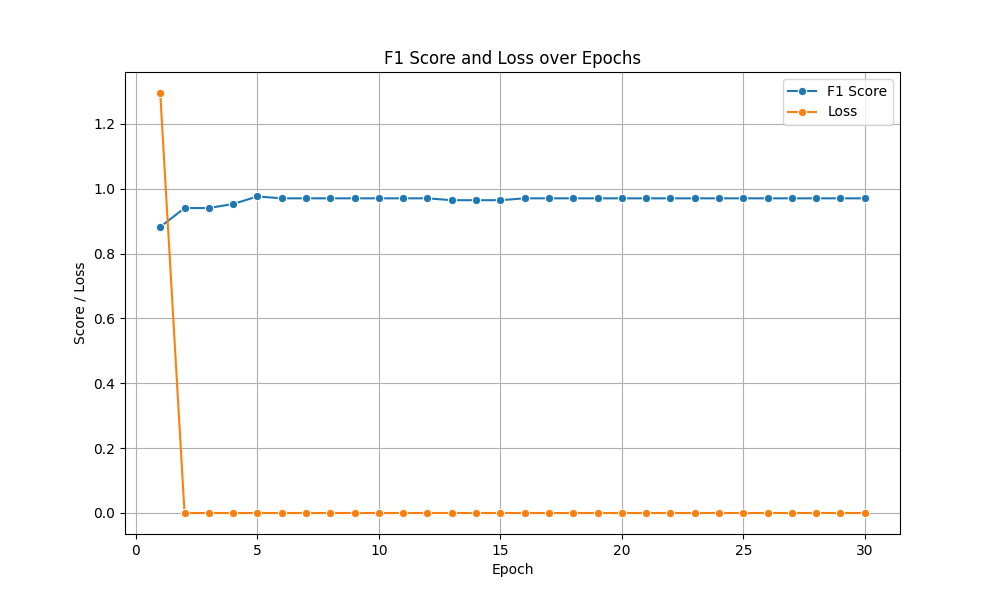

In [4]:
model.image

In [5]:
def pad_sequences(sequences, max_len):
        padded_sequences = cupy.zeros((len(sequences), max_len, sequences[0].shape[1]))
        for i, seq in enumerate(sequences):
            length = min(seq.shape[0], max_len)
            padded_sequences[i, :length] = seq[:length]
        return padded_sequences

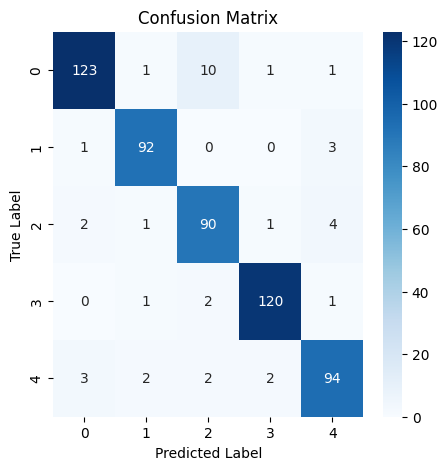

In [6]:
import numpy as np
from sklearn.metrics import confusion_matrix,f1_score
import seaborn as sns
import matplotlib.pyplot as plt

X_test= pad_sequences(X_test, max_words_per_phrase)

predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

# Convert one-hot encoded true labels to class labels
y_true = np.argmax(y_test, axis=1) 
# Compute confusion matrix
cm = confusion_matrix(y_true.get(), y_pred.get(), labels=np.arange(5))

# Visualize the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.arange(5), yticklabels=np.arange(5))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [7]:
f1_score(y_pred.get(),y_true.get(),average="weighted")

0.9315994518146911

In [22]:
f1_score(y_pred.get(),y_true.get(),average=None)

array([0.891, 0.936, 0.904, 0.964, 0.912])

In [213]:
f1_score(y_pred,y_true,average=None)

array([0.808     , 0.76190476, 0.8       , 0.88311688, 0.81052632])

In [216]:
f1_score(y_pred,y_true,average=None)

array([0.82071713, 0.7816092 , 0.83937824, 0.89686099, 0.80874317])

In [219]:
f1_score(y_pred,y_true,average=None)

array([0.83464567, 0.82634731, 0.78974359, 0.88596491, 0.88888889])